# Bfastmonitor CPU using Python
## This is bfastmonitor Python

In [1]:
import os
import wget
import numpy as np
from datetime import datetime

from bfast import BFASTMonitor
from bfast.utils import crop_data_dates

import copy

import matplotlib
import matplotlib.pyplot as plt

#from sar so extra
import csv
from shutil import copyfile
import pandas as pd
from osgeo import gdal
from osgeo import gdal_array
from osgeo import osr

import time
import ipywidgets as widgets

from ipyfilechooser import FileChooser
import folium

#specific imports
from functions import set_output_dir, get_size, get_data_dict

In [2]:
%matplotlib inline

## Select a time series folder using ipyfilechooser. The standard download location is in downloads/time_series_name/[0,1,3]

### Optional: select a name for your output folder. 

In [3]:
from os.path import expanduser
path = expanduser("~")

def g(directory):
    return(directory)
                          
output_directory_chooser = widgets.interactive(g, 
                        directory=widgets.Text(description="Output storage name:", 
                                               style = {'description_width': 'initial'},
                                               placeholder = "output"))
file_chooser = FileChooser(path)

display(file_chooser)
display(output_directory_chooser)



FileChooser(path='/home/dven', filename='', show_hidden='False')

interactive(children=(Text(value='', description='Output storage name:', placeholder='output', style=Descripti…

In [5]:
timeseries_directory = file_chooser.selected
print(timeseries_directory)
set_output_dir(output_directory_chooser)


#timeseries_directory = "/home/dven/downloads/Time_series_2020-07-10_13-33-30/" #big (rwanda presumably)
#timeseries_directory = "/home/dven/downloads/Time_series_2020-07-07_11-51-35_Portugal/1/" #small

/home/dven/downloads/Time_series_2020-07-07_11-51-35_Portugal/1/
Defaulting to output directory name "output" 


In [6]:
print(get_size(start_path = timeseries_directory), 'bytes')
# 4926249639 bytes gave a memory error for m16, m48 could handle this.. but it takes long.. didn't let it run
# 6457220347 bytes 6.45 gb did not give a memory error for m16.. not sure why? maybe the new file structure? took 2334 seconds
# which is like 39 minutes
# 1452244352 bytes took just a minute tho.. whuu


1680334 bytes


In [70]:
from osgeo import gdal
import matplotlib.pyplot as plt
import numpy as np

class Timeseries:
    '''
    
    This is a class that holds a numpy array with associated geographical metadata.
    
    '''
    
    def __init__(self, time_series_path,dates_path):
        
        self.name = time_series_path
        
        time_series = gdal.Open(time_series_path)
        geotransform = time_series.GetGeoTransform()
        
        self.xpixelsize = geotransform[1]
        self.ypixelsize = geotransform[5]
        self.latitude = geotransform[3]
        self.longitude = geotransform[0]

        self.ncols = time_series.RasterXSize
        self.nrows = time_series.RasterYSize
        self.projection = time_series.GetProjection()
        self.raster_stack = time_series.ReadAsArray()
        self.nbands = time_series.RasterCount
        
        with open(dates_path) as f:
            dates_list = f.read().split('\n')
            self.dates = [datetime.strptime(d, '%Y-%m-%d') for d in dates_list if len(d) > 0]
        
    def __str__(self):
        return("Timeseries holds {} dates, sized {} by {}.".format(self.nbands,
                                                                        self.ncols,
                                                                        self.nrows))

    def plot_hist(self):
        histlist = []
        for x in range(self.nbands):
            histlist.append(np.isnan(self.raster_stack[x]).sum()/(self.ncols*self.nrows))
        plt.hist(histlist)
        plt.show()
            
      

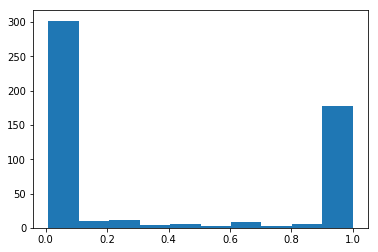

In [68]:
data.plot_hist()

# Load in data

In [71]:
start_time = time.time()

# # set paths to data
dates_path = os.path.join(timeseries_directory, "dates.csv")
#data_dict = {}
data_list=[]
tile_paths = []

# # check for tiles
for file in os.listdir(timeseries_directory):
    if file.startswith('tile'):
        time_series_path = os.path.join(timeseries_directory, file, 'stack.vrt') ## never start os path with a slash
        tile_paths.append(time_series_path)

        
        

# # load in time series and its metadata
if not tile_paths:
    print("No tiles, loading in data as a whole")
    time_series_path = os.path.join(timeseries_directory, 'stack.vrt')
    data = Timeseries(time_series_path, dates_path)
    
else:
    print("Data consists of tiles, loading in tiles one by one")
    for time_series_path in tile_paths:
        #data_dict[time_series_path] = get_data_dict(time_series_path)
        data_list.append(get_data_dict(time_series_path))
        data = Timeseries(time_series_path, dates_path)
        end_time = time.time()
        print(tile, ' loaded \n', "Loading data took {} seconds.".format(end_time - start_time))

# Save time
end_time = time.time()
print("Total loading took {} seconds.".format(end_time - start_time))

# log
with open("log.txt","a") as file:
    file.write("Loading in: " + timeseries_directory)
    file.write(" took {} seconds.".format(end_time - start_time))
    file.write("\n")

print(data_list)

No tiles, loading in data as a whole
Total loading took 2.6633663177490234 seconds.
[]


In [72]:
data.dates

[datetime.datetime(2000, 1, 8, 0, 0),
 datetime.datetime(2000, 1, 24, 0, 0),
 datetime.datetime(2000, 3, 28, 0, 0),
 datetime.datetime(2000, 5, 15, 0, 0),
 datetime.datetime(2000, 7, 18, 0, 0),
 datetime.datetime(2000, 9, 4, 0, 0),
 datetime.datetime(2000, 10, 22, 0, 0),
 datetime.datetime(2000, 11, 7, 0, 0),
 datetime.datetime(2000, 11, 23, 0, 0),
 datetime.datetime(2000, 1, 16, 0, 0),
 datetime.datetime(2000, 3, 4, 0, 0),
 datetime.datetime(2000, 3, 20, 0, 0),
 datetime.datetime(2000, 4, 5, 0, 0),
 datetime.datetime(2000, 5, 7, 0, 0),
 datetime.datetime(2000, 5, 23, 0, 0),
 datetime.datetime(2000, 6, 8, 0, 0),
 datetime.datetime(2000, 6, 24, 0, 0),
 datetime.datetime(2000, 7, 10, 0, 0),
 datetime.datetime(2000, 7, 26, 0, 0),
 datetime.datetime(2000, 8, 11, 0, 0),
 datetime.datetime(2000, 8, 27, 0, 0),
 datetime.datetime(2000, 9, 12, 0, 0),
 datetime.datetime(2000, 10, 14, 0, 0),
 datetime.datetime(2000, 11, 15, 0, 0),
 datetime.datetime(2000, 12, 1, 0, 0),
 datetime.datetime(2001, 2,

# Store metadata

In [73]:
#Fabians code

# here one may loop over the data_list and run the whole bfastmonitor, or choose a tile
raster_stack = data.raster_stack
data_orig = raster_stack



# Set parameters

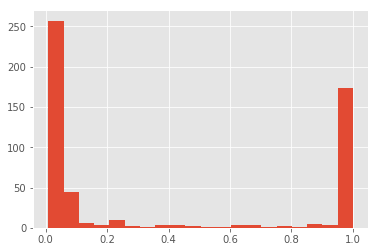

In [112]:
# parameters
k = 3
freq = 365
trend = False
hfrac = 0.25
level = 0.05
start_hist = datetime(2000, 1, 1)
start_monitor = datetime(2010, 1, 1)
end_monitor = datetime(2018, 1, 1)
position = (100,100)


# Select monitoring period

In [113]:
start_date = dates[10] # 0 or 10 does not work.. 100 did
print("start monitoring period",start_date)
end_date = dates[-1]

def h(y):
    return(y)

pandas_dates = pd.date_range(start_date, end_date, freq='D')

options = [(date.strftime(' %d %b %Y '), date) for date in pandas_dates]
index = (0, len(options)-1)


start_end_date = widgets.interactive(h,
                                     y=widgets.SelectionRangeSlider(
                                            options=options,
                                            index=index,
                                            description='Select the monitoring date range: ',
                                            style = {'description_width': 'initial'},
                                            orientation='horizontal',
                                            layout={'width': '800px',"height":"200px"}))
display(start_end_date)

start monitoring period 2000-03-04 00:00:00


interactive(children=(SelectionRangeSlider(description='Select the monitoring date range: ', index=(0, 7400), …

In [114]:
start_monitor, end_monitor = start_end_date.result
print("start monitor: ",start_monitor)
print("end monitor: ",end_monitor)

start monitor:  2009-06-06 00:00:00
end monitor:  2020-06-07 00:00:00


In [115]:
data, dates = crop_data_dates(data_orig, dates, start_hist, end_monitor)
print("First date: {}".format(dates[0]))
print("Last date: {}".format(dates[-1]))
print("Shape of data array: {}".format(data.shape))
start_hist

First date: 2000-01-08 00:00:00
Last date: 2020-06-07 00:00:00
Shape of data array: (529, 8, 14)


datetime.datetime(2000, 1, 1, 0, 0)

# Run bfastmonitor()

In [116]:
# fit BFAST using the CPU implementation (single pixel)
from numpy import nan

start_time = time.time()


model = BFASTMonitor(
            start_monitor,
            freq=freq,
            k=k,
            hfrac=hfrac,
            trend=trend,
            level=level,
            backend='python',
            verbose=1
            )


# only apply on a small subset
data = data[:,:200,:200]
model.fit(data, dates, nan_value=nan) #changed to nan

end_time = time.time()
print("Fitting model took {} seconds.".format(end_time - start_time))


Processing row 0
Processing row 1
Processing row 2
Processing row 3
Processing row 4
Processing row 5
Processing row 6
Processing row 7
Fitting model took 1.5352685451507568 seconds.


# Select negative magnitudes

In [117]:
# select only negative magnitudes
breaks = model.breaks # index of date that has a break in dates
means = model.means # magnitudes of breaks

no_breaks_indices = (breaks == -1)
means[no_breaks_indices] = 0
means[means > 0] = 0 # only want negative mean changes

breaks_plot = breaks.astype(np.float)
breaks_plot[breaks == -2] = np.nan
breaks_plot[breaks == -1] = np.nan
breaks_plot[means >= 0] = np.nan


In [118]:
dates_monitor = []

# collect dates for monitor period
for i in range(len(dates)):
    if start_monitor <= dates[i]:
        dates_monitor.append(dates[i])
dates_array = np.array(dates_monitor) # dates_array is the dates that are in the monitoring period


# Classify output for plotting

In [119]:
idx_starts = {}

# this gives the index of all the data points in the year and after
for year in range(start_monitor.year,end_monitor.year):
    idx_starts[year] = np.argmax((dates_array >= datetime(year, 1, 1)) > False) 
    
print(idx_starts)
breaks_plot_years = copy.deepcopy(breaks_plot)

#classifying for plotting
ticklist=[]
for idx, year in enumerate(idx_starts):
    ticklist.append(str(year))

    if idx == 0:
        breaks_plot_years[breaks_plot <= idx_starts[year+1]] = 0
        continue
    
    if idx == len(idx_starts)-1:
        breaks_plot_years[np.where(idx_starts[year] < breaks_plot)] = len(idx_starts)-1
        continue
        
    breaks_plot_years[np.where(np.logical_and(idx_starts[year] < breaks_plot, breaks_plot <= idx_starts[year+1]))] = idx
print(ticklist)
print(breaks_plot_years)

{2009: 0, 2010: 13, 2011: 28, 2012: 43, 2013: 55, 2014: 84, 2015: 116, 2016: 157, 2017: 198, 2018: 237, 2019: 271}
['2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019']
[[ 7.  3.  4.  4.  1.  5.  3.  3.  3.  6.  0.  0.  6.  6.]
 [ 6.  0.  6.  6.  2.  6.  8.  8.  5.  3.  1.  1.  1.  6.]
 [ 4.  5. nan nan nan  6.  0.  0.  0.  0.  5.  5.  4.  1.]
 [ 4.  4.  0.  0.  3.  0.  0.  0.  3.  4.  3.  3.  4.  1.]
 [ 4.  0.  0.  0.  6.  4.  4.  4.  3.  6.  0.  0.  2.  1.]
 [ 0.  0.  5.  5.  4.  2.  0.  0.  0.  0.  4.  4.  0.  0.]
 [ 0.  6.  6.  6.  4. nan  1.  1.  0.  0.  0.  0.  0.  5.]
 [nan  6.  6.  6.  0. nan  4.  4.  1.  3.  0.  0.  0.  6.]]


# Plot output

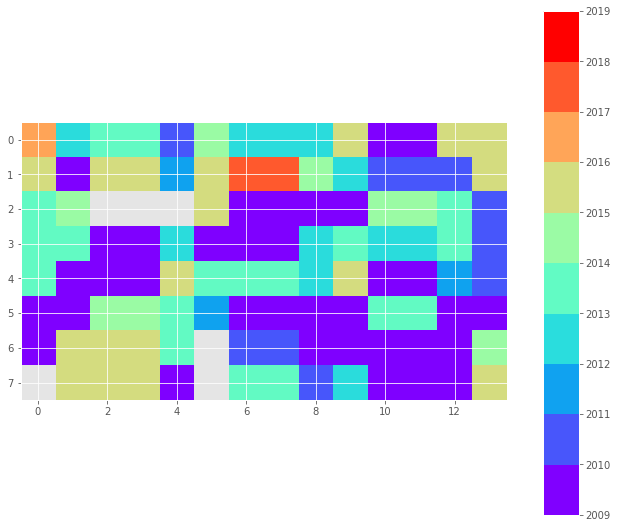

In [120]:
bins = len(idx_starts)

cmap = plt.get_cmap("rainbow")
cmaplist = [cmap(i) for i in range(cmap.N)]
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

bounds = np.linspace(0, bins-1, bins) #third number is the amount of bins in the colorbar 0=0, 6 = ncolors, 7= nyears
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
im = axes.imshow(breaks_plot_years, cmap=cmap, vmin=0, vmax=bins, norm=norm)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax, ticks=range(bins))
labels = cbar_ax.set_yticklabels(ticklist)

plt.savefig("./output/picture.png")
plt.show()


In [53]:
# #this doesn't work yet

# output_raster = gdal.GetDriverByName('GTiff').Create('myraster.tif',cols, rows, 1 ,gdal.GDT_Float32)  # Open the file

# output_raster.SetGeoTransform(geotransform)  # Specify its coordinates
# srs = osr.SpatialReference()                 # Establish its coordinate encoding
# srs.ImportFromEPSG(4326)                     # This one specifies WGS84 lat long.
#                                              # Anyone know how to specify the 
#                                              # IAU2000:49900 Mars encoding?
# output_raster.SetProjection( srs.ExportToWkt() )   # Exports the coordinate system 
#                                                    # to the file
# output_raster.GetRasterBand(1).WriteArray(breaks_plot_years)   # Writes my array to the raster

# output_raster.FlushCache()

# output_raster

In [98]:
print(breaks_plot_years)
breaks_plot_years_norm = 1/(breaks_plot_years + 0.01)
print(breaks_plot_years_norm)

[[ 5.  1.  4.  4.  0.  5.  2.  2.  1.  4.  0.  0.  4.  4.]
 [ 4.  0.  4.  4.  6.  6.  6.  6.  3.  4.  1.  1.  2.  4.]
 [ 2.  3. nan nan nan  4.  0.  0.  0.  3.  3.  3.  2.  3.]
 [ 3.  2.  2.  2.  1.  2.  2.  2.  1.  2.  1.  1.  2.  0.]
 [ 2.  2.  2.  2.  4.  2.  2.  2.  1.  4.  2.  2.  0.  0.]
 [ 2.  2.  2.  2.  2.  1.  2.  2.  0.  0.  2.  2.  1.  2.]
 [ 4.  4.  4.  4.  2. nan  4.  4.  4.  4.  2.  2.  2.  2.]
 [nan  4.  4.  4. nan nan  3.  3.  2.  1.  2.  2.  4.  4.]]
[[  0.1996008    0.99009901   0.24937656   0.24937656 100.
    0.1996008    0.49751244   0.49751244   0.99009901   0.24937656
  100.         100.           0.24937656   0.24937656]
 [  0.24937656 100.           0.24937656   0.24937656   0.16638935
    0.16638935   0.16638935   0.16638935   0.33222591   0.24937656
    0.99009901   0.99009901   0.49751244   0.24937656]
 [  0.49751244   0.33222591          nan          nan          nan
    0.24937656 100.         100.         100.           0.33222591
    0.33222591   0.3322

In [99]:
#cmap = plt.get_cmap("Oranges")

#cmaplist = [cmap(i) for i in range(cmap.N)]

#cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# viridis = cm.get_cmap('viridis', 12)
# print(viridis)
# print(viridis(0.56))

viridis = cm.get_cmap('rainbow', 256)
newcolors = viridis(np.linspace(0, 1, 256))
pink = np.array([248/256, 24/256, 148/256, 0])
newcolors[:1, :] = pink
newcmp = ListedColormap(newcolors)

In [100]:
print(latitude)
print(xpixelsize)
print(cols)
print(longitude)
print(ypixelsize)
print(rows)

NameError: name 'latitude' is not defined

In [101]:
from folium.plugins import FloatImage
import base64
m = folium.folium.Map(location = (latitude,longitude),tiles = "Stamen Terrain",zoom_start=13)

# if not all data is 
#rows = 200
#cols = 200


# bounds = [[lat_min, lon_min], [lat_max, lon_max]]

folium.raster_layers.ImageOverlay(
    image=breaks_plot_years_norm,
    bounds=[[latitude, longitude], [latitude + rows*xpixelsize, longitude + cols*xpixelsize]],
    colormap = newcmp
).add_to(m)
img = "output/picture.png" 


####
resolution, width, height = 75, 4,4
encoded = base64.b64encode(open("output/picture.png", 'rb').read()).decode()
from folium import IFrame

html = '<img src="data:image/png;base64,{}">'.format
iframe = IFrame(html(encoded), width=(width*resolution)+20, height=(height*resolution)+20)
popup = folium.Popup(iframe, max_width=2650)

icon = folium.Icon(color="red", icon="ok")
marker = folium.Marker(location=[latitude, longitude], popup=popup, icon=icon)
marker.add_to(m)
####

m.save(os.path.join('output/PortugalBigger.html'))
m

NameError: name 'latitude' is not defined